# Neural Network Demystified Practice

In [147]:
class Neural_Network(object):
    def __init__(self, Lambda=0):
        #Define HyperParameters
        self.inputLayerSize = 2
        self.outputLayerSize = 1
        self.hiddenLayerSize = 3
        
        #Weights (Parameters)
        self.W1 = np.random.randn(self.inputLayerSize, \
                                 self.hiddenLayerSize)
        self.W2 = np.random.randn(self.hiddenLayerSize, \
                                 self.outputLayerSize)
        
        #Regularization Parameter
        self.Lambda = Lambda       
        
    def forward(self, X):
        #Propagate inputs through network
        self.z2 = np.dot(X, self.W1)
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2, self.W2)
        yHat = self.sigmoid(self.z3)
        return yHat
    
    def sigmoid(self, z):
        return 1./(1.+np.exp(-z))
    
    def sigmoidPrime(self, z):
        #Derivative of Sigmoid Function
        return np.exp(-z)/((1+np.exp(-z))**2)
    
    def costFunction(self, X, y):
        #Compute cost for given X,y, use weights already stored in class.
        self.yHat = self.forward(X)
        J = 0.5*sum((y-self.yHat)**2)/X.shape[0]+(self.Lambda/2.)*(sum(self.W1**2)+sum(self.W2**2))
        return J

    def costFunctionPrime(self, X, y):
        #compute derivative with respect to W1 and W2
        self.yHat = self.forward(X)
        
        delta3 = np.multiply(-(y-self.yHat), self.sigmoidPrime(self.z3))
        dJdW2 = np.dot(self.a2.T, delta3)/X.shape[0] + self.Lambda*self.W2
        
        delta2 = np.dot(delta3, self.W2.T)*self.sigmoidPrime(self.z2)
        dJdW1 = np.dot(X.T, delta2)/X.shape[0] + self.Lambda*self.W1
        
        return dJdW1, dJdW2
    
    #Helper Functions for interacting with other classes:
    def getParams(self):
        #Get W1 and W2 unrolled into vector:
        params = np.concatenate((self.W1.ravel(), self.W2.ravel()))
        return params
    
    def setParams(self, params):
        #Set W1 and W2 using single parameter vector.
        W1_start = 0
        W1_end = self.hiddenLayerSize * self.inputLayerSize
        self.W1 = np.reshape(params[W1_start:W1_end],(self.inputLayerSize, \
                                                     self.hiddenLayerSize))
        W2_end = W1_end + self.hiddenLayerSize * self.outputLayerSize
        self.W2 = np.reshape(params[W1_end:W2_end], (self.hiddenLayerSize, \
                                                    self.outputLayerSize))
        
    def computeGradients(self, X, y):
        dJdW1, dJdW2 = self.costFunctionPrime(X,y)
        return np.concatenate((dJdW1.ravel(), dJdW2.ravel()))

In [148]:
def computeNumericalGradient(N, X, y):
    paramsInitial = N.getParams()
    numgrad = np.zeros(paramsInitial.shape)
    perturb = np.zeros(paramsInitial.shape)
    e = 1e-4
    
    for p in range(len(paramsInitial)):
        #Set perturbation vector
        perturb[p] = e
        N.setParams(paramsInitial + perturb)
        loss2 = N.costFunction(X,y)
        
        N.setParams(paramsInitial - perturb)
        loss1 = N.costFunction(X,y)
        
        #compute Numerical Gradient
        numgrad[p] = (loss2 - loss1)/(2*e)
        
        #Return the value we changed to zero:
        perturb[p] = 0
        
    #Return Params to original value:
    N.setParams(paramsInitial)
    
    return numgrad

In [149]:
import numpy as np

X = np.array([[3,5],[5,1],[10,2]])
y = np.array([[0.75],[0.82],[0.93]])

X = X/np.amax(X, axis=0)

In [150]:
NN = Neural_Network(Lambda=0.001)

In [151]:
cost1 = NN.costFunction(X,y)

In [152]:
dJdW1, dJdW2 = NN.costFunctionPrime(X,y)

In [153]:
dJdW1

array([[-0.00322848,  0.01215184,  0.00043068],
       [-0.00360342,  0.00878705,  0.00155484]])

In [154]:
dJdW2

array([[-0.03346893],
       [-0.04117463],
       [-0.03513778]])

In [155]:
learningRate = 3

In [156]:
NN.W1 = NN.W1 + learningRate*dJdW1
NN.W2 = NN.W2 + learningRate*dJdW2
cost2 = NN.costFunction(X,y)

In [157]:
print(cost1, cost2)

0.0869928143793 0.100369837163


In [158]:
dJdW1, dJdW2 = NN.costFunctionPrime(X,y)
NN.W1 = NN.W1 - learningRate*dJdW1
NN.W2 = NN.W2 - learningRate*dJdW2
cost3 = NN.costFunction(X,y)

In [159]:
print(cost2, cost3)

0.100369837163 0.0860741795496


## numerical gradient checking (unit test for costFunctionPrime)

In [160]:
numgrad = computeNumericalGradient(NN, X, y)

In [161]:
grad = NN.computeGradients(X,y)

In [162]:
norm(grad-numgrad)/norm(grad+numgrad)

1.0537230195681624e-10

## BFGS

In [163]:
from scipy import optimize

In [164]:
class trainer(object):
    def __init__(self, N):
        #Make local reference to network:
        self.N = N
    
    def callbackF(self, params):
        self.N.setParams(params)
        self.J.append(self.N.costFunction(self.X, self.y))
        
    def costFunctionWrapper(self, params, X, y):
        self.N.setParams(params)
        cost = self.N.costFunction(X,y)
        grad = self.N.computeGradients(X,y)
        
        return cost, grad
    
    def train(self, X, y):
        #Make an internal variable for the callback function:
        self.X = X
        self.y = y
        
        #Make empty list to store costs:
        self.J = []
        
        params0 = self.N.getParams()
        
        options = {'maxiter':200, 'disp': True}
        _res = optimize.minimize(self.costFunctionWrapper, params0, jac=True, \
                                method='BFGS', args=(X,y), options=options,  \
                                callback=self.callbackF)
        self.N.setParams(_res.x)
        self.optimizationResults = _res

In [165]:
T = trainer(NN)

In [166]:
T.train(X, y)

Optimization terminated successfully.
         Current function value: 0.003313
         Iterations: 56
         Function evaluations: 59
         Gradient evaluations: 59


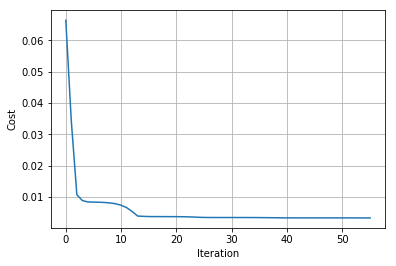

In [167]:
plot(T.J)
grid(1)
xlabel('Iteration')
ylabel('Cost')

In [168]:
NN.costFunctionPrime(X,y)

(array([[  1.20140527e-07,  -2.18935440e-07,   4.10309413e-06],
        [ -4.87276351e-06,  -7.78218689e-06,  -8.74233103e-06]]),
 array([[  3.03192269e-06],
        [ -2.01355573e-06],
        [ -2.76595625e-06]]))

In [169]:
NN.forward(X)

array([[ 0.7922106 ],
       [ 0.82553069],
       [ 0.84771434]])

In [170]:
y

array([[ 0.75],
       [ 0.82],
       [ 0.93]])

In [171]:
#Test network for various combinations of sleep/study
hoursSleep = linspace(0, 10, 100)
hoursStudy = linspace(0, 5, 100)

#Normalize data (same way training data was normalized)
hoursSleepNorm = hoursSleep/10.
hoursStudyNorm = hoursStudy/5.

#Create 2-d versions of input for plotting
a, b =meshgrid(hoursSleepNorm, hoursStudyNorm)

#Join into a single input matrix:
allInputs = np.zeros((a.size, 2))
allInputs[:, 0] = a.ravel()
allInputs[:, 1] = b.ravel()

In [172]:
allOutputs = NN.forward(allInputs)

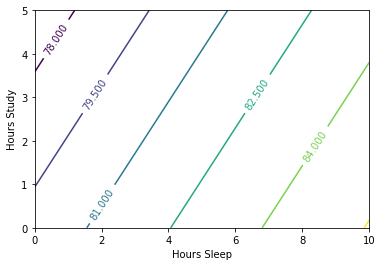

In [173]:
#Contour Plot:
yy = np.dot(hoursStudy.reshape(100,1), np.ones((1,100)))
xx = np.dot(hoursSleep.reshape(100,1), np.ones((1,100))).T

CS = contour(xx,yy,100*allOutputs.reshape(100,100))
clabel(CS, inline=1, fontsize=10)
xlabel('Hours Sleep')
ylabel('Hours Study')

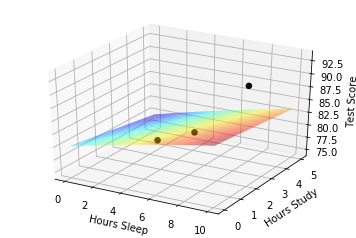

In [176]:
#3D plot:

##Uncomment to plot out-of-notebook (you'll be able to rotate)
#%matplotlib qt

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.scatter(10*X[:,0], 5*X[:,1], 100*y, c='k', alpha = 1, s=30)


surf = ax.plot_surface(xx, yy, 100*allOutputs.reshape(100, 100), \
                       cmap=cm.jet, alpha = 0.5)

ax.set_xlabel('Hours Sleep')
ax.set_ylabel('Hours Study')
ax.set_zlabel('Test Score')